# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей
## Разделение выборки на обучающую и тестовую


In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets  import load_digits
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Загрузка данных
mnist = load_digits()

In [0]:
# Разделение выборки на обучающую и тестовую
mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = train_test_split(
    mnist.data, mnist.target, test_size=0.5, random_state=1)

In [5]:
mnist_X_train.shape, mnist_y_train.shape

((898, 64), (898,))

In [6]:
mnist_X_test.shape, mnist_y_test.shape

((899, 64), (899,))

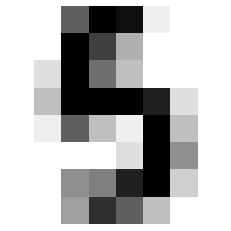

In [7]:
some_digit_image = mnist_X_train[400].reshape(8, 8)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
mnist_y_train[400]

5

## Обучение модели ближайших соседей для произвольно заданного гиперпараметра K. Оценка качества модели с помощью трёх метрик

In [0]:
# 5 ближайших соседей
cl1_1 = KNeighborsClassifier(n_neighbors=5)
cl1_1.fit(mnist_X_train, mnist_y_train)
target1_0 = cl1_1.predict(mnist_X_train)
target1_1 = cl1_1.predict(mnist_X_test)

In [10]:
# Доля правильных ответов алгоритма
accuracy_score(mnist_y_train, target1_0), accuracy_score(mnist_y_test, target1_1)

(0.9899777282850779, 0.9799777530589544)

In [11]:
# Доля объектов, названных классификатором положительными и при этом действительно являющимися положительными
precision_score(mnist_y_train, target1_0, average=None)

array([1.        , 0.96703297, 0.9787234 , 0.98823529, 0.98780488,
       0.99009901, 1.        , 1.        , 1.        , 0.98717949])

In [12]:
precision_score(mnist_y_test, target1_1, average=None)

array([1.        , 0.97849462, 0.98809524, 0.97      , 1.        ,
       0.95180723, 0.98876404, 0.95698925, 0.97530864, 0.9893617 ])

In [13]:
# recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм
recall_score(mnist_y_train, target1_0, average='macro'), recall_score(mnist_y_test, target1_1, average='macro')

(0.9898771140578082, 0.9806170493417093)

In [14]:
# В моделях k-ближайших соседей с увеличением значения k 
# увеличивается смещение и уменьшается дисперсия (слишком большое k приводит к недообучению)
# 10 ближайших соседей
cl1_2 = KNeighborsClassifier(n_neighbors=10)
cl1_2.fit(mnist_X_train, mnist_y_train)
target2_0 = cl1_2.predict(mnist_X_train)
target2_1 = cl1_2.predict(mnist_X_test)
accuracy_score(mnist_y_train, target2_0), accuracy_score(mnist_y_test, target2_1)

(0.9799554565701559, 0.9710789766407119)

## Построение модели и оценка качества модели с использованием кросс-валидации

In [0]:
# Вызов функции cross_val_score для кросс-валидации
scores = cross_val_score(KNeighborsClassifier(n_neighbors=10), 
                         mnist.data, mnist.target, cv=10)

In [16]:
# Значение метрики accuracy для 10 фолдов
scores

array([0.91666667, 0.96111111, 0.97222222, 0.93888889, 0.96666667,
       0.98333333, 0.98888889, 0.97765363, 0.96089385, 0.95530726])

In [17]:
# Среднее значение метрики accuracy для 10 фолдов
np.mean(scores)

0.9621632526381129

In [18]:
# Использование метрики f1
scores = cross_val_score(KNeighborsClassifier(n_neighbors=10), 
                         mnist.data, mnist.target, cv=10,
                        scoring='f1_weighted')
scores, np.mean(scores)

(array([0.91474195, 0.96104777, 0.97244799, 0.93898203, 0.96644704,
        0.9831524 , 0.98888031, 0.97760645, 0.96068606, 0.95493778]),
 0.9618929765733577)

In [0]:
# Метрики, которые будем использовать для оценки качества модели
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [20]:
# Функция cross_validate для оценки с помощью нескольких метрик
scores = cross_validate(KNeighborsClassifier(n_neighbors=10), 
                        mnist.data, mnist.target, scoring=scoring, 
                        cv=10, return_train_score=True)
scores

{'fit_time': array([0.01576948, 0.00755596, 0.00787687, 0.00787926, 0.0079844 ,
        0.00777769, 0.00796008, 0.0079248 , 0.0079987 , 0.0078187 ]),
 'score_time': array([0.04423237, 0.04391098, 0.04231501, 0.04263425, 0.04265451,
        0.04274893, 0.04265451, 0.04173398, 0.04164004, 0.04190183]),
 'test_f1': array([0.91474195, 0.96104777, 0.97244799, 0.93898203, 0.96644704,
        0.9831524 , 0.98888031, 0.97760645, 0.96068606, 0.95493778]),
 'test_precision': array([0.93139542, 0.96753247, 0.97518797, 0.9436566 , 0.96894737,
        0.98421053, 0.98947368, 0.97853572, 0.96254574, 0.95716398]),
 'test_recall': array([0.91666667, 0.96111111, 0.97222222, 0.93888889, 0.96666667,
        0.98333333, 0.98888889, 0.97765363, 0.96089385, 0.95530726]),
 'train_f1': array([0.9844917 , 0.98574665, 0.98696972, 0.98511204, 0.9851002 ,
        0.98576152, 0.98636386, 0.98388195, 0.98577298, 0.98762115]),
 'train_precision': array([0.98491213, 0.98596648, 0.98716176, 0.98537304, 0.98534177,
   

## Проведение экспериментов с тремя различными стратегиями кросс-валидации

In [21]:
# Стратегия K-fold для функции cross_validate
kf = KFold(n_splits=5)
scores = cross_validate(KNeighborsClassifier(n_neighbors=5), 
                        mnist.data, mnist.target, scoring=scoring,
                        cv=kf, return_train_score=True)
scores

{'fit_time': array([0.01068306, 0.00687766, 0.00687814, 0.00686908, 0.00685811]),
 'score_time': array([0.0775063 , 0.07499599, 0.07293797, 0.07227254, 0.07261443]),
 'test_f1': array([0.95033368, 0.96400864, 0.96365932, 0.9803475 , 0.96355834]),
 'test_precision': array([0.95347854, 0.9661858 , 0.96530458, 0.98115182, 0.9649334 ]),
 'test_recall': array([0.95      , 0.96388889, 0.9637883 , 0.98050139, 0.9637883 ]),
 'train_f1': array([0.99163407, 0.99092694, 0.9902288 , 0.99022858, 0.99094678]),
 'train_precision': array([0.9917003 , 0.99100688, 0.99025538, 0.99033507, 0.99099086]),
 'train_recall': array([0.99164927, 0.99095338, 0.99026426, 0.99026426, 0.99095967])}

In [22]:
# Стратегия Repeated K-Fold для функции cross_val_score
kf = RepeatedKFold(n_splits=3, n_repeats=2)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), 
                         mnist.data, mnist.target, scoring='f1_weighted', 
                         cv=kf)
scores, np.mean(scores)

(array([0.98323043, 0.98487247, 0.98498542, 0.98662699, 0.98328913,
        0.98664745]), 0.9849419821481821)

In [23]:
# Стратегия ShuffleSplit для функции cross_val_score
kf = ShuffleSplit(n_splits=5, test_size=0.25)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), 
                         mnist.data, mnist.target, scoring='f1_weighted', 
                         cv=kf)
scores, np.mean(scores)

(array([0.98669483, 0.98229053, 0.98453847, 0.98661747, 0.98442114]),
 0.9849124877184892)

## Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации

In [24]:
# Варианты значений, принимаемых параметром
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [25]:
# Применение GridSearchCV и кросс-валидации K-fold
%%time
kf = KFold(n_splits=5)
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=kf, scoring='accuracy')
clf_gs.fit(mnist.data, mnist.target)

CPU times: user 4.18 s, sys: 5.73 ms, total: 4.19 s
Wall time: 4.19 s


In [26]:
# Наилучшее найденное значение гиперпараметра K равно 5
clf_gs.best_params_

{'n_neighbors': 5}

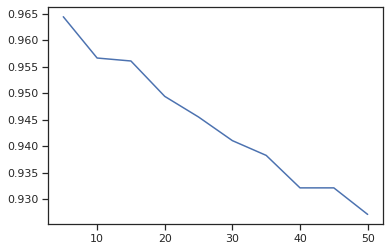

In [27]:
# График качества обучения модели в зависимости от выбранного гиперпараметра K
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

## Обучение модели ближайших соседей и оценка качества с учётом подобранных гиперпараметров

In [0]:
clf_gs.best_estimator_.fit(mnist_X_train, mnist_y_train)
target3_0 = clf_gs.best_estimator_.predict(mnist_X_train)
target3_1 = clf_gs.best_estimator_.predict(mnist_X_test)

In [29]:
# Новое качество модели
accuracy_score(mnist_y_train, target3_0), accuracy_score(mnist_y_test, target3_1)

(0.9899777282850779, 0.9799777530589544)

In [30]:
# Качество модели до подбора гиперпараметра уступает качеству модели после подбора гиперпараметра
accuracy_score(mnist_y_train, target2_0), accuracy_score(mnist_y_test, target2_1)

(0.9799554565701559, 0.9710789766407119)

## Построение кривых обучения и валидации

In [0]:
# Строится зависимость метрики на обучающей выборке от размера выборки
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [0]:
# Строится зависимость метрики на тестовой выборке от одного из гиперпараметров
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

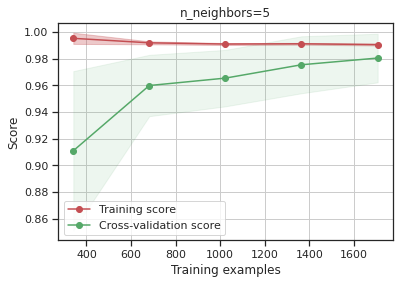

In [39]:
plot_learning_curve(clf_gs.best_estimator_, 'n_neighbors=5', 
                    mnist.data, mnist.target, cv=20, train_sizes=np.linspace(.2, 1.0, 5))

In [0]:
n_range2 = np.array(range(5,1000,50))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

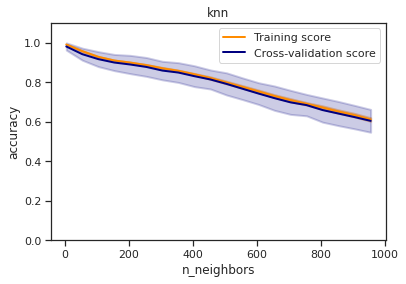

In [45]:
plot_validation_curve(clf_gs.best_estimator_, 'knn', 
                      mnist.data, mnist.target, 
                      param_name='n_neighbors', param_range=n_range2, 
                      cv=20, scoring="accuracy")